# Statistics of the RUNS

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def get_formatted_data(output_name, error_name, launches, kind='parallel'):
    """
    output_name: name of the output file of the run;
    error_name: name of the error file of the run;
    launches: a list. Every element is the numbere of core involved in the run.
              i.e. launces = [1, 1, 2, 3, 5] means that in the output and error
              files there are the result of a run with one core, followed by
              another run with one core, followed by a run with two cores, followed
              by a run with three cores, followd by a run with five cores.
    
    It outputs a list of dictionaries, one for each launch. The information provided
    in the dictionary are the following:
    - P: the number of cores;
    - trials: the numbrer of trials of the process (Niter);
    - estimate: the estimate of pi resulting from the process;
    - ealpsed_t: the elapsed time as measured by /usr/bin/time;
    - procs_t: a list of the wall times of each processor. The 0th element is the wall
               time of the master node;
    - CUP: the usage of CPU (normalied: 100% is 1.00).
    """
    assert(kind in ['serial', 'parallel'])
    data = []
    trials_re = re.compile(" # of trials = (.*) ,")
    estimate_re = re.compile("estimate of pi is (.*) ")
    if kind == 'parallel':
        master_t_re = re.compile("master processor : (.*) ")
    elif kind == 'serial':
        master_t_re = re.compile("walltime : (.*)")
    elapsed_t_re = re.compile("system (.*)elapsed ")
    cpu_re = re.compile("elapsed (.*)%CPU ")
    with open(output_name, "r") as output, open(error_name, "r") as error:
        for launch in launches:
            o_chunk = ""
            o_line_n = 0
            e_chunk = ""
            while o_line_n <= launch:
                o_line = output.readline()
                if o_line != '\n':
                    o_line_n += 1
                    o_chunk += o_line
            #global last_chunk_o 
            #last_o_chunk = o_chunk
            trials = int(trials_re.search(o_chunk).group(1))
            estimate = float(estimate_re.search(o_chunk).group(1))
            master_t = float(master_t_re.search(o_chunk).group(1))
            procs_t = [master_t] + [float(re.compile("on processor {} : (.*) ".format(proc)).search(o_chunk).group(1)) for proc in range(1, launch)]
            e_chunk += error.readline()
            e_chunk += error.readline()
            elapsed_s = elapsed_t_re.search(e_chunk).group(1).split(":")
            elapsed_t = float(elapsed_s[-1]) + 60 * float(elapsed_s[-2])
            cpu = float(cpu_re.search(e_chunk).group(1))/100
            data.append({"P": launch,
                         "trials": trials,
                         "estimate": estimate,
                         "elapsed_t": elapsed_t,
                         "procs_t": procs_t,
                         "CPU": cpu
                         })
        return data

## SERIAL extraction

In [3]:
serial_launches = 3 * [1]
serial_exps = [8, 9, 10, 11]

serial_basename = "serial/2/serial2-"
serial_output_extension = ".output"
serial_error_extension = ".error"

serial_arguments = {s: (serial_basename + "{:02d}".format(s) + serial_output_extension, serial_basename + "{:02d}".format(s) + serial_error_extension, serial_launches) for s in serial_exps}
serial_results = {key: get_formatted_data(*args, kind='serial') for key, args in serial_arguments.items()}

## STRONG extraction

In [4]:
strong_launches = [launch for launch in [1, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48] for i in range(3)]
strong_exps = [8, 9, 10, 11]

strong_basename = "strong/parallel-"
strong_output_extension = ".output"
strong_error_extension = ".error"

strong_arguments = {s: (strong_basename + "{:02d}".format(s) + strong_output_extension, strong_basename + "{:02d}".format(s) + strong_error_extension, strong_launches) for s in strong_exps}
strong_results = {key: get_formatted_data(*(args), kind='parallel') for key, args in strong_arguments.items()}

## WEAK extraction

In [5]:
weak_launches_1 = 3 * [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48]
weak_exps_1 = [8, 9, 10]
weak_launches_2 = 3 * [12, 24, 48]
weak_exps_2 = [11]

weak_basename = "weak/w_parallel-"
weak_output_extension = ".output"
weak_error_extension = ".error"

weak_arguments = {s: (weak_basename + "{:02d}".format(s) + weak_output_extension, weak_basename + "{:02d}".format(s) + weak_error_extension, weak_launches_1) for s in weak_exps_1}
weak_arguments.update({s: (weak_basename + "{:02d}".format(s) + weak_output_extension, weak_basename + "{:02d}".format(s) + weak_error_extension, weak_launches_2) for s in weak_exps_2})
weak_results = {key: get_formatted_data(*(args), kind='parallel') for key, args in weak_arguments.items()}

## Some Sanity Checks

In [6]:
strong_dev_p = []
for proc in strong_results.values():
    for el in proc:
        na = np.array(el['procs_t'])
        strong_dev_p.append({'P': el['P'], 'trials': el['trials'] ,'dev_p':(na.max() - na.min()) / na.mean()})

In [7]:
strong_dev_df = pd.DataFrame(strong_dev_p)
strong_dev_df['dev_p'].describe()

count    156.000000
mean       0.038591
std        0.059417
min        0.000000
25%        0.002471
50%        0.014356
75%        0.042306
max        0.265560
Name: dev_p, dtype: float64

In [8]:
strong_dev_df.loc[strong_dev_df['dev_p'].idxmax()]

P         4.000000e+01
trials    1.000000e+08
dev_p     2.655600e-01
Name: 30, dtype: float64

In [9]:
weak_dev_p = []
for proc in weak_results.values():
    for el in proc:
        na = np.array(el['procs_t'])
        weak_dev_p.append({'P': el['P'], 'trials': el['trials'] ,'dev_p':(na.max() - na.min()) / na.mean()})

In [10]:
weak_dev_df = pd.DataFrame(weak_dev_p)
weak_dev_df['dev_p'].describe()

count    1.170000e+02
mean     2.082666e-02
std      2.352683e-02
min      8.513529e-07
25%      2.664554e-03
50%      1.195196e-02
75%      3.263498e-02
max      9.634714e-02
Name: dev_p, dtype: float64

In [11]:
weak_dev_df.loc[weak_dev_df['dev_p'].idxmax()]

P         4.400000e+01
trials    4.400000e+11
dev_p     9.634714e-02
Name: 94, dtype: float64

## Averages

### Serial

In [12]:
def get_serial_tabs(results):
    serial_df = {key: pd.DataFrame(value) for key, value in results.items()}

    serial_tabs = dict()
    for exp, data in serial_df.items():
        data['max_proc_t'] = data['procs_t'].apply(max)
        groups = data[['P', 'elapsed_t', 'max_proc_t']].groupby('P')
        key = list(groups.groups.keys())[0]
        tab = groups.get_group(key).iloc[:, 1:].transpose()
        avg = tab.mean(axis=1)
        max_dev = tab.max(axis=1) - tab.min(axis=1)
        tab.insert(0, 'max_dev', max_dev)
        tab.insert(0, 'avg', avg)
        serial_tabs[exp] = tab
        
    return serial_tabs

serial_tabs = get_serial_tabs(serial_results)
serial_tabs

{8:                  avg  max_dev     0     1     2
 elapsed_t   2.583333     0.07  2.63  2.56  2.56
 max_proc_t  2.560000     0.00  2.56  2.56  2.56,
 9:                   avg  max_dev      0     1      2
 elapsed_t   25.743333     0.13  25.83  25.7  25.70
 max_proc_t  25.736667     0.13  25.82  25.7  25.69,
 10:                    avg  max_dev       0       1       2
 elapsed_t   256.783333      0.6  256.61  256.57  257.17
 max_proc_t  256.753333      0.6  256.58  256.54  257.14,
 11:                     avg  max_dev        0        1        2
 elapsed_t   2601.813333    86.54  2659.50  2572.98  2572.96
 max_proc_t  2601.556667    86.55  2659.25  2572.70  2572.72}

### Parallel

In [13]:
def get_parallel_tabs(results, csv_name):
    df = {key: pd.DataFrame(value) for key, value in results.items()}

    tabs = dict()
    for exp, data in df.items():
        data['max_proc_t'] = data['procs_t'].apply(max)
        groups = data[['P', 'max_proc_t', 'elapsed_t']].groupby('P')
        keys = list(groups.groups.keys())
        tt = []
        for key in keys:
            tab = groups.get_group(key).iloc[:,1:]
            tab = tab.transpose()
            tab.columns = ['run1', 'run2', 'run3']
            avg = tab.mean(axis=1)
            max_dev = tab.max(axis=1) - tab.min(axis=1)
            tab.insert(0, 'error_bar', max_dev)
            tab.insert(0, 'avg', avg)
            tab = tab.unstack().to_frame().swaplevel().sort_index().transpose()
            tab.index = [key]
            tab.index.name = 'GPU processors'
            tt.append(tab)
        this_df = pd.concat(tt)
        tabs[exp] = this_df
        this_df['max_proc_t'].to_csv(csv_name.format(exp), index=True)
        
    return tabs

strong_tabs = get_parallel_tabs(strong_results, "strong-scalability-10to{:02d}.csv")
weak_tabs = get_parallel_tabs(weak_results, "weak-scalability-10to{:02d}.csv")

### Strong

In [14]:
strong_tabs[8]

elapsed_t                             max_proc_t            \
                     avg error_bar  run1  run2  run3        avg error_bar   
GPU processors                                                              
1               2.860000      0.09  2.92  2.83  2.83   2.574571  0.006347   
4               0.943333      0.01  0.95  0.94  0.94   0.645152  0.002675   
8               0.660000      0.00  0.66  0.66  0.66   0.322926  0.000322   
12              0.606667      0.01  0.61  0.61  0.60   0.219340  0.007800   
16              0.600000      0.00  0.60  0.60  0.60   0.166487  0.005038   
20              0.633333      0.01  0.64  0.63  0.63   0.136469  0.001447   
24              0.676667      0.01  0.68  0.68  0.67   0.116436  0.002459   
28              0.800000      0.04  0.78  0.82  0.80   0.104824  0.014016   
32              0.846667      0.06  0.88  0.84  0.82   0.106450  0.025414   
36              0.926667      0.03  0.93  0.91  0.94   0.094328  0.009464   
40              1.046667      0.04  1.04  1.03  1.07   0.094900  0.032796   
44              1.240000      0.08  1.24  1.28  1.20   0.121156  0.040213   
48              1.316667      0.03  1.32  1.33  1.30   0.121926  0.029080   

                                              
                    run1      run2      run3  
GPU processors                                
1               2.571225  2.574916  2.577572  
4               0.644498  0.644141  0.646816  
8               0.322922  0.323089  0.322767  
12              0.223122  0.219576  0.215322  
16              0.168479  0.163442  0.167541  
20              0.137301  0.135854  0.136252  
24              0.117973  0.115820  0.115514  
28              0.099722  0.113738  0.101013  
32              0.114982  0.089567  0.114801  
36              0.098707  0.095033  0.089243  
40              0.090661  0.080622  0.113418  
44              0.132991  0.135345  0.095132  
48              0.134731  0.125395  0.105651

In [15]:
strong_tabs[9]

elapsed_t                                max_proc_t            \
                      avg error_bar   run1   run2   run3        avg error_bar   
GPU processors                                                                  
1               25.986667      0.10  26.05  25.96  25.95  25.718885  0.044167   
4                6.770000      0.04   6.79   6.77   6.75   6.460049  0.011540   
8                3.580000      0.03   3.59   3.56   3.59   3.233128  0.019372   
12               2.593333      0.08   2.58   2.56   2.64   2.194731  0.060416   
16               2.100000      0.07   2.07   2.09   2.14   1.657038  0.062452   
20               1.843333      0.05   1.84   1.87   1.82   1.342665  0.037758   
24               1.703333      0.06   1.74   1.69   1.68   1.135961  0.056327   
28               1.726667      0.04   1.75   1.72   1.71   1.037304  0.012795   
32               1.656667      0.03   1.66   1.67   1.64   0.926934  0.021227   
36               1.743333      0.03   1.74   1.76   1.73   0.866298  0.023110   
40               1.763333      0.13   1.69   1.78   1.82   0.779068  0.046999   
44               1.853333      0.20   1.93   1.73   1.90   0.778114  0.132104   
48               1.996667      0.22   2.14   1.93   1.92   0.805813  0.148574   

                                                 
                     run1       run2       run3  
GPU processors                                   
1               25.747108  25.706605  25.702941  
4                6.466363   6.458961   6.454823  
8                3.237111   3.221451   3.240823  
12               2.176955   2.173411   2.233827  
16               1.634050   1.640563   1.696502  
20               1.329004   1.366762   1.332228  
24               1.172174   1.115847   1.119863  
28               1.042123   1.029328   1.040460  
32               0.916405   0.937632   0.926765  
36               0.864099   0.878952   0.855843  
40               0.751559   0.787089   0.798557  
44               0.843288   0.711183   0.779871  
48               0.900906   0.752332   0.764203

In [16]:
strong_tabs[10]

elapsed_t                                    max_proc_t  \
                       avg error_bar    run1    run2    run3         avg   
GPU processors                                                             
1               257.803333      0.72  258.05  258.03  257.33  257.502792   
4                64.766667      0.01   64.76   64.77   64.77   64.438898   
8                32.780000      0.32   32.96   32.74   32.64   32.428240   
12               22.360000      0.65   22.78   22.17   22.13   21.953314   
16               16.916667      0.05   16.90   16.95   16.90   16.469270   
20               14.086667      0.42   14.24   14.20   13.82   13.574826   
24               11.996667      0.48   11.73   12.21   12.05   11.425700   
28               11.170000      0.04   11.17   11.15   11.19   10.466157   
32               10.056667      0.34    9.97    9.93   10.27    9.289822   
36                9.223333      0.14    9.14    9.28    9.25    8.378715   
40                8.656667      0.15    8.66    8.73    8.58    7.714428   
44                8.343333      0.56    8.23    8.12    8.68    7.194753   
48                7.626667      0.02    7.62    7.64    7.62    6.443424   

                                                              
               error_bar        run1        run2        run3  
GPU processors                                                
1               0.700756  257.730032  257.739550  257.038795  
4               0.032952   64.418042   64.447657   64.450994  
8               0.322456   32.600524   32.406128   32.278068  
12              0.655640   22.375164   21.765252   21.719524  
16              0.065308   16.452456   16.510331   16.445024  
20              0.399776   13.716788   13.690677   13.317012  
24              0.490171   11.149961   11.640131   11.487007  
28              0.010975   10.472740   10.461765   10.463967  
32              0.331672    9.213991    9.161901    9.493573  
36              0.189514    8.299075    8.488588    8.348482  
40              0.248138    7.731894    7.829765    7.581626  
44              0.507754    7.025592    7.025456    7.533210  
48              0.056458    6.423502    6.426809    6.479960

In [17]:
strong_tabs[11]

elapsed_t                                        max_proc_t  \
                        avg error_bar     run1     run2     run3          avg   
GPU processors                                                                  
1               2585.560000     36.25  2571.16  2578.11  2607.41  2585.260183   
4                666.550000     59.73   651.58   644.17   703.90   668.427476   
8                337.086667     39.41   363.24   323.83   324.19   336.698747   
12               217.373333      2.40   218.73   217.06   216.33   216.937533   
16               165.023333      1.54   164.93   165.84   164.30   164.548543   
20               133.266667      0.61   132.88   133.43   133.49   132.728236   
24               112.813333      1.17   112.41   112.45   113.58   112.207015   
28               103.963333      0.35   103.84   104.19   103.86   103.261598   
32                94.020000      0.55    93.91    94.35    93.80    93.227405   
36                84.150000      0.55    84.26    83.82    84.37    83.262993   
40                77.680000      1.91    77.59    76.77    78.68    76.707597   
44                70.650000      0.37    70.60    70.86    70.49    69.556784   
48                66.220000      1.29    66.69    65.40    66.57    65.030212   

                                                                  
                error_bar         run1         run2         run3  
GPU processors                                                    
1               36.247981  2570.862164  2577.808238  2607.110145  
4               53.059576   651.235670   650.493590   703.553166  
8               39.385104   362.838430   323.453326   323.804487  
12               2.397149   218.291851   216.626046   215.894703  
16               1.554537   164.461693   165.369237   163.814700  
20               0.600694   132.347257   132.889499   132.947951  
24               1.189418   111.798114   111.835399   112.987532  
28               0.359556   103.123793   103.483349   103.177652  
32               0.529112    93.123469    93.543928    93.014816  
36               0.591671    83.370420    82.913443    83.505114  
40               1.876911    76.624893    75.810494    77.687405  
44               0.374670    69.514253    69.765384    69.390714  
48               1.360581    65.571811    64.211230    65.307594

### Weak

In [18]:
for i in weak_tabs:
    weak_tabs[i] = pd.concat([strong_tabs[i].loc[1].to_frame().transpose(), weak_tabs[i]])

In [19]:
weak_tabs[8]

elapsed_t                             max_proc_t                      \
         avg error_bar  run1  run2  run3        avg error_bar      run1   
1   2.860000      0.09  2.92  2.83  2.83   2.574571  0.006347  2.571225   
4   2.886667      0.01  2.89  2.88  2.89   2.582566  0.009104  2.580564   
8   2.933333      0.01  2.93  2.94  2.93   2.591035  0.006351  2.593644   
12  3.010000      0.03  3.00  3.00  3.03   2.605894  0.030773  2.595215   
16  3.063333      0.01  3.07  3.06  3.06   2.617236  0.012094  2.624599   
20  3.220000      0.06  3.19  3.25  3.22   2.706101  0.079089  2.663461   
24  3.286667      0.11  3.25  3.25  3.36   2.713763  0.104744  2.678249   
28  3.593333      0.11  3.55  3.66  3.57   2.901495  0.077640  2.871472   
32  3.776667      0.15  3.78  3.70  3.85   3.019421  0.146967  3.022272   
36  3.916667      0.11  3.86  3.92  3.97   3.067699  0.153028  2.998718   
40  3.986667      0.07  3.97  4.03  3.96   3.028825  0.020393  3.015793   
44  4.190000      0.06  4.22  4.19  4.16   3.096306  0.089278  3.147201   
48  4.370000      0.27  4.53  4.26  4.32   3.184499  0.226015  3.313315   

                        
        run2      run3  
1   2.574916  2.577572  
4   2.588119  2.579015  
8   2.587293  2.592168  
12  2.596479  2.625988  
16  2.614605  2.612505  
20  2.742550  2.712294  
24  2.680047  2.782993  
28  2.949112  2.883901  
32  2.944512  3.091479  
36  3.052634  3.151746  
40  3.034498  3.036185  
44  3.083795  3.057923  
48  3.087300  3.152883

In [20]:
weak_tabs[9]

elapsed_t                                max_proc_t                       \
          avg error_bar   run1   run2   run3        avg error_bar       run1   
1   25.986667      0.10  26.05  25.96  25.95  25.718885  0.044167  25.747108   
4   26.073333      0.06  26.06  26.05  26.11  25.763913  0.040263  25.759818   
8   26.320000      0.29  26.17  26.33  26.46  25.965550  0.309153  25.802431   
12  26.423333      0.11  26.35  26.46  26.46  26.025468  0.109796  25.952538   
16  26.683333      0.04  26.67  26.67  26.71  26.237223  0.037150  26.225425   
20  27.066667      0.14  27.04  27.15  27.01  26.554748  0.149147  26.529370   
24  28.000000      1.21  28.31  28.45  27.24  27.423717  1.220403  27.726052   
28  30.310000      1.67  29.78  29.74  31.41  29.586215  1.616975  29.119260   
32  30.060000      0.08  30.03  30.11  30.04  29.324606  0.074801  29.313703   
36  30.663333      1.05  30.34  31.35  30.30  29.837792  1.039196  29.543751   
40  31.460000      0.84  31.07  31.40  31.91  30.490855  0.843802  30.105972   
44  32.963333      1.92  33.70  31.78  33.41  31.890137  2.026867  32.663884   
48  32.236667      0.17  32.34  32.17  32.20  31.051127  0.106757  31.119753   

                          
         run2       run3  
1   25.706605  25.702941  
4   25.745830  25.786093  
8   25.982634  26.111584  
12  26.061531  26.062334  
16  26.224547  26.261697  
20  26.642011  26.492863  
24  27.882751  26.662348  
28  29.011205  30.628179  
32  29.367458  29.292657  
36  30.504410  29.465214  
40  30.416819  30.949774  
44  30.637017  32.369510  
48  31.012995  31.020633

In [21]:
weak_tabs[10]

elapsed_t                                    max_proc_t             \
           avg error_bar    run1    run2    run3         avg  error_bar   
1   257.803333      0.72  258.05  258.03  257.33  257.502792   0.700756   
4   258.850000      0.60  259.06  259.03  258.46  258.516814   0.630697   
8   262.230000     10.49  269.05  258.56  259.08  261.846695  10.472941   
12  261.116667      2.45  261.08  259.91  262.36  260.681835   2.449361   
16  264.923333      5.66  268.32  262.66  263.79  264.444208   5.660744   
20  273.160000      9.63  276.35  266.75  276.38  272.622309   9.644622   
24  268.596667      2.82  267.10  268.77  269.92  267.788703   2.206252   
28  292.476667      4.54  293.79  289.55  294.09  291.739885   4.550742   
32  295.606667      4.44  296.72  292.83  297.27  294.827331   4.462900   
36  301.376667     11.54  308.73  298.21  297.19  300.491393  11.568886   
40  311.096667     12.51  310.54  305.12  317.63  310.091087  12.481932   
44  317.890000     20.94  312.33  331.14  310.20  316.758843  20.989675   
48  319.276667     21.33  328.07  306.74  323.02  318.042314  21.278536   

                                        
          run1        run2        run3  
1   257.730032  257.739550  257.038795  
4   258.749832  258.681475  258.119135  
8   268.659592  258.186651  258.693843  
12  260.646103  259.475021  261.924382  
16  267.840555  262.179812  263.312257  
20  275.815186  266.203560  275.848182  
24  266.495635  268.168587  268.701887  
28  293.043287  288.812813  293.363555  
32  295.936561  292.041266  296.504166  
36  307.855948  297.331168  296.287062  
40  309.543718  304.123806  316.605738  
44  311.169475  330.048364  309.058689  
48  326.806406  305.527870  321.792666

In [22]:
weak_tabs[11]

elapsed_t                                        max_proc_t              \
            avg error_bar     run1     run2     run3          avg   error_bar   
1   2585.560000     36.25  2571.16  2578.11  2607.41  2585.260183   36.247981   
12  2611.960000     14.80  2610.70  2619.99  2605.19  2611.608157   15.058640   
24  2724.906667     81.73  2708.61  2773.92  2692.19  2724.290688   81.746204   
48  3104.643333    146.03  3196.42  3067.12  3050.39  3103.422166  145.981685   

                                           
           run1         run2         run3  
1   2570.862164  2577.808238  2607.110145  
12  2610.263828  2619.809641  2604.751001  
24  2707.985955  2773.316157  2691.569954  
48  3195.182882  3065.882419  3049.201196

## GRAPHS

In [31]:
def graphs(serial, parallel, draw_identity=False):
    assert(serial.keys() == parallel.keys())
    
    fig_sum_w, ax_sum_w = plt.subplots()
    fig_sum_e, ax_sum_e = plt.subplots()
    
    idx_s = set()
    for exp, data in parallel.items():
        fig_a, ax_a = plt.subplots()
        ax_a.errorbar(data.index, data['elapsed_t']['avg'], data['elapsed_t']['error_bar'],zorder=10)
        ax_a.errorbar(data.index, data['max_proc_t']['avg'], data['max_proc_t']['error_bar'],zorder=1)
        ax_a.set_title("Timing: $N = 10^{{{:d}}}$".format(exp))
        ax_a.set_xlabel("cores")
        ax_a.set_ylabel("time [s]")
        ax_a.legend(['walltime', 'elapsed'])
        
        fig_s, ax_s = plt.subplots()
        ax_s.plot(serial[exp]['avg']['elapsed_t'] / data['elapsed_t']['avg'],zorder=10)
        ax_s.plot(serial[exp]['avg']['max_proc_t'] / data['max_proc_t']['avg'],zorder=1)
        if draw_identity:
            ax_s.plot(data.index, data.index)
        ax_s.set_title("Scaling: $N = 10^{{{:d}}}$".format(exp))
        ax_s.set_xlabel("cores")
        ax_s.set_ylabel("speedup")
        legend = ["walltime", "elapsed"]
        if draw_identity:
            legend.append("theoretical")
        ax_s.legend(legend)
        
        idx_s.update(set(data.index))
        
        ax_sum_e.plot(serial[exp]['avg']['elapsed_t'] / data['elapsed_t']['avg'])
        ax_sum_w.plot(serial[exp]['avg']['max_proc_t'] / data['max_proc_t']['avg'])
        
    idx = list(idx_s)
    
    sum_legend = ["$N = 10^{{{:d}}}$".format(exp) for exp in parallel.keys()]
    if draw_identity:
        sum_legend.append("theoretical")
 
    if draw_identity:
        ax_sum_w.plot(idx, idx)    
    ax_sum_w.set_title("Scaling summary: walltime")
    ax_sum_w.set_xlabel("cores")
    ax_sum_w.set_ylabel("speedup")
    ax_sum_w.legend(sum_legend)
    
    if draw_identity:
        ax_sum_e.plot(idx, idx) 
    ax_sum_e.set_title("Scaling summary: elapsed time")
    ax_sum_e.set_xlabel("cores")
    ax_sum_e.set_ylabel("speedup")
    ax_sum_e.legend(sum_legend)
    
    plt.show()
        

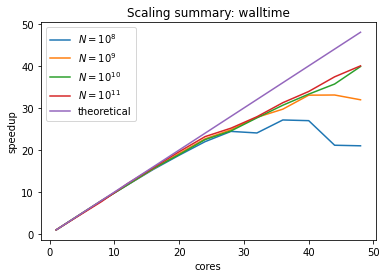

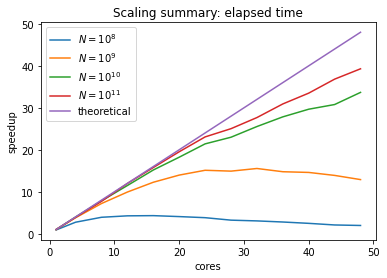

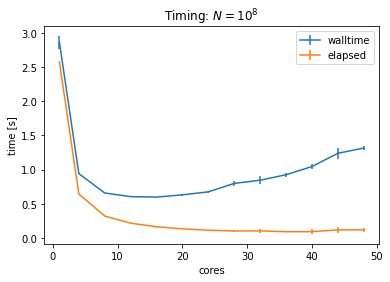

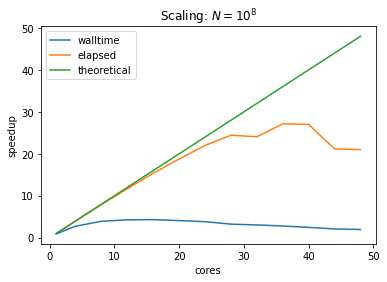

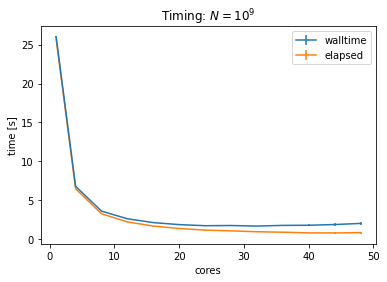

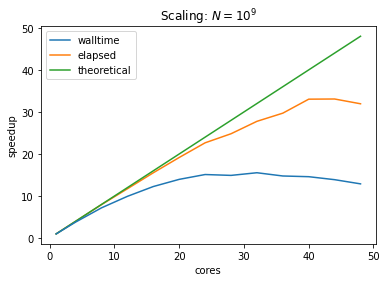

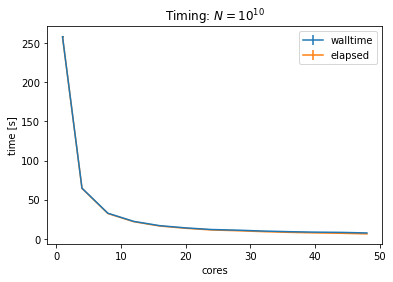

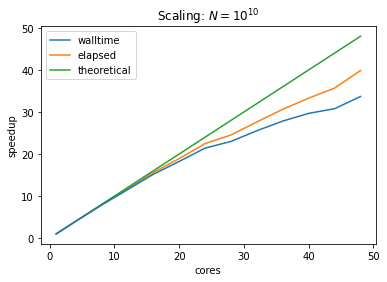

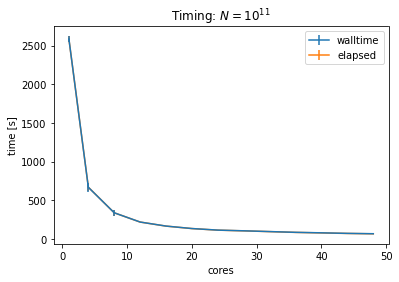

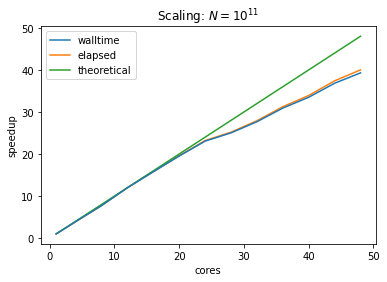

In [32]:
graphs(serial_tabs, strong_tabs, draw_identity=True)

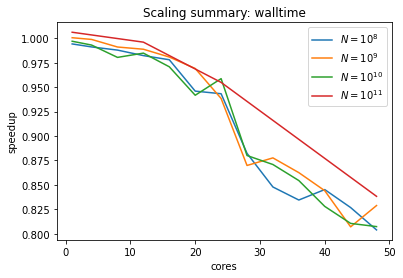

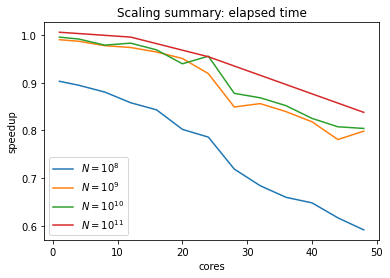

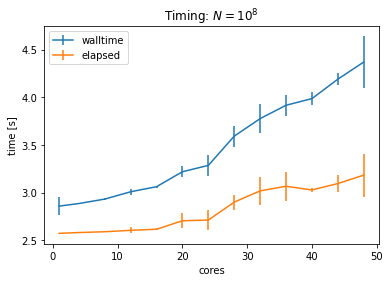

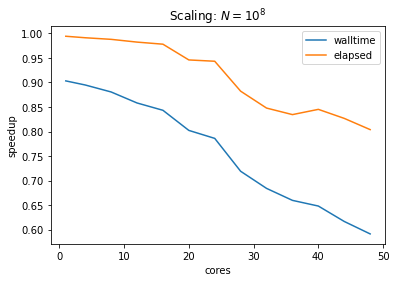

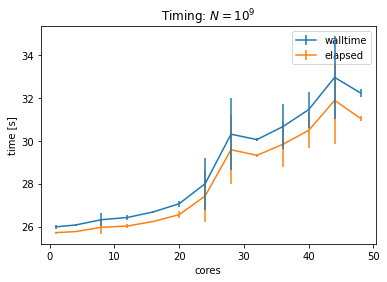

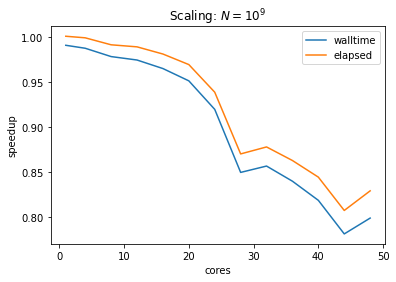

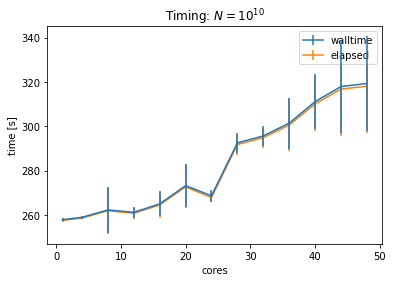

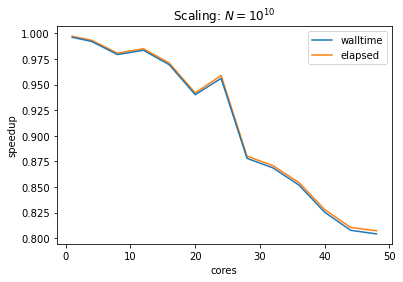

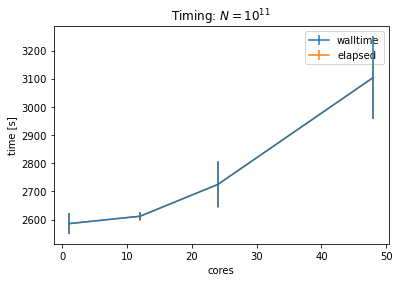

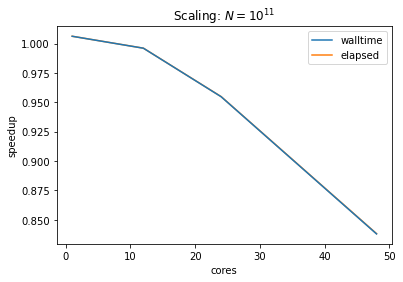

In [34]:
graphs(serial_tabs, weak_tabs)

## Parallel Overhead

In [182]:
def overhead_tab(serial, parallel):
    assert(serial.keys() == parallel.keys())
    overhead_t = dict()
    for exp, data in parallel.items():
        max_proc_oh = data[('max_proc_t', 'avg')] * data.index - serial_tabs[exp].loc['max_proc_t', 'avg']
        max_proc_err = data[('max_proc_t', 'error_bar')] * data.index + serial_tabs[exp].loc['max_proc_t', 'max_dev']
        elapsed_oh = data[('elapsed_t', 'avg')] * data.index - serial_tabs[exp].loc['elapsed_t', 'avg']
        elapsed_err = data[('elapsed_t', 'error_bar')] * data.index + serial_tabs[exp].loc['elapsed_t', 'max_dev']
        overhead_t[exp] = pd.DataFrame({('max_proc_t', 'overhead'): max_proc_oh,
                                        ('max_proc_t', 'err_bar'): max_proc_err,
                                        ('elapsed_t', 'overhead'): elapsed_oh,
                                        ('elapsed_t', 'err_bar'): elapsed_err})
        
    return overhead_t

In [187]:
overhead_tabs = overhead_tab(serial_tabs, strong_tabs)
overhead_tabs[11]

max_proc_t               elapsed_t        
                  overhead     err_bar    overhead err_bar
GPU processors                                            
1               -16.296484  122.797981  -16.253333  122.79
4                72.153235  298.788304   64.386667  325.46
8                92.033313  401.630829   94.880000  401.82
12                1.693732  115.315785    6.666667  115.34
16               31.220028  111.422593   38.560000  111.18
20               53.008047   98.563887   63.520000   98.74
24               91.411696  115.096027  105.706667  114.62
28              289.768080   96.617557  309.160000   96.34
32              381.720279  103.481572  406.826667  104.14
36              395.911068  107.850165  427.586667  106.34
40              466.747227  161.626453  505.386667  162.94
44              458.941822  103.035465  506.786667  102.82
48              519.893494  151.857882  576.746667  148.46

In [234]:
def overhead_graphs(tabs):
    legend = [r"$N = 10^{{{:d}}}$".format(exp) for exp in tabs]
    
    fig_w, ax_w = plt.subplots()
    fig_e, ax_e = plt.subplots()


    for key, tab in tabs.items():
        ax_w.errorbar(tab.index, tab['max_proc_t']['overhead'],tab['max_proc_t']['err_bar'])
        ax_e.errorbar(tab.index, tab['elapsed_t']['overhead'], tab['elapsed_t']['err_bar'])
     
    ax_w.set_yscale("log")
    ax_w.set_title("Overhead: walltime")
    ax_w.set_xlabel("cores")
    ax_w.set_ylabel("overhead [s]")
    ax_w.legend(legend)
    
    ax_e.set_yscale("log")
    ax_e.set_title("Overhead: elapsed time")
    ax_e.set_xlabel("cores")
    ax_e.set_ylabel("overhead [s]")
    ax_e.legend(legend)
    
    plt.show()
    print(legend)

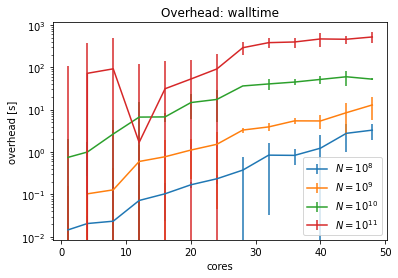

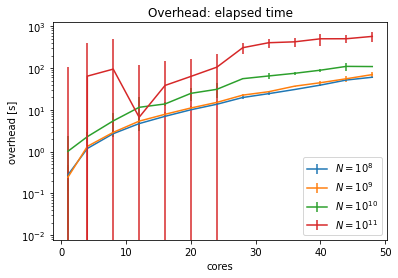

['$N = 10^{8}$', '$N = 10^{9}$', '$N = 10^{10}$', '$N = 10^{11}$']


In [235]:
overhead_graphs(overhead_tabs)